In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models
import random

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, forecast_top_k_trials
from main.seir.sensitivity import calculate_sensitivity_and_plot
import main.seir.uncertainty as uncertainty_module
from utils.generic.create_report import save_dict_and_create_report_simple
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [33]:
predictions_dict = {}

In [74]:
config_filename = 'experiments/undetected.yaml'
config = read_config(config_filename)

In [75]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

### undetected testing model fitting

Performing m1 fit ..
parameters used to generate data: {'beta': 0.211, 'T_inc': 5, 'T_inf_D': 3.3, 'T_inf_U': 5.5, 'd': 0.011, 'T_recov_severe': 21, 'T_recov_fatal': 25, 'P_fatal': 0.3, 'E_hosp_ratio': 2, 'I_D_hosp_ratio': 2, 'I_U_hosp_ratio': 3, 'psi': 1}
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 38                  | 39                  | 40                  | 41                  | 42                  |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-14 00:00:00 | 2020-09-15 00:00:00 | 2020-09-16 00:00:00 | 2020-09-17 00:00:00 | 2020-09-18 00:00:00 |
| S           | 9135737.0           | 9118443.0           | 9101087.0           | 9083671.0           | 9066199.0           |
| E           | 84320.0             | 84711.0             | 85087.0   

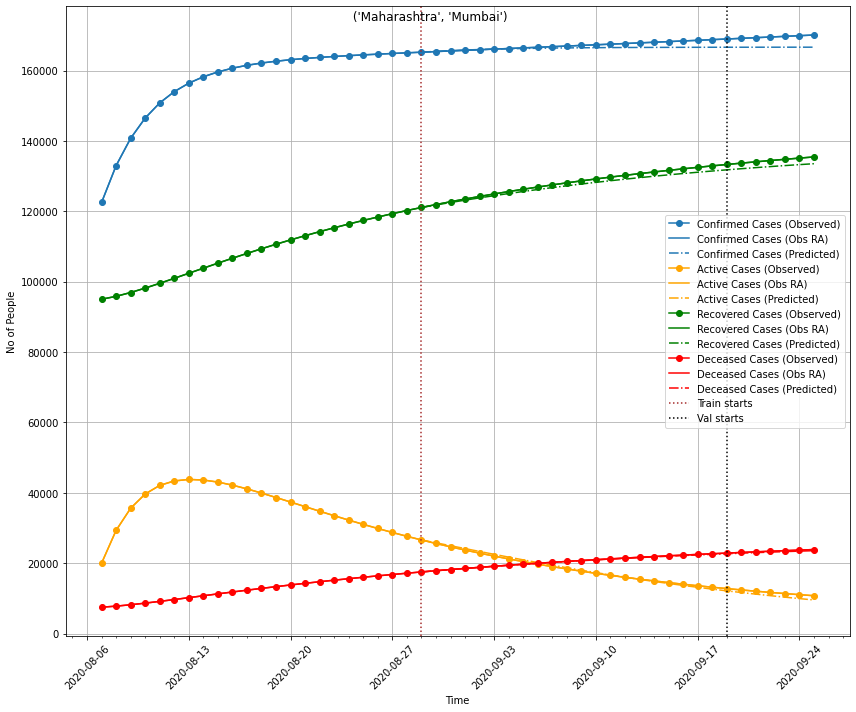

In [78]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

# m2_params = copy.deepcopy(config['fitting'])
# m2_params['split']['val_period'] = 0
# predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [55]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 1.2228026204829072,
 'I_D_hosp_ratio': 0.10701600712979609,
 'I_U_hosp_ratio': 1.0491317819703339,
 'P_fatal': 0.08802421234313276,
 'T_inc': 4.398017994604978,
 'T_inf_D': 3.241588621596782,
 'T_inf_U': 4.779388591298772,
 'T_recov_fatal': 3.8548242390714202,
 'T_recov_severe': 24.130127842761812,
 'beta': 0.9774587623139606,
 'd': 0.000930824946534084,
 'lockdown_R0': 0.702743928648235}

## Loss Dataframes

### M1 Loss DataFrame

In [56]:
predictions_dict['m1']['df_loss']

,train,val
total,0.652576,1.40871
active,1.0601,11.7983
recovered,1.3685,3.06482
deceased,4.3429,13.1806


In [14]:
sum([0.25*i for i in predictions_dict['m1']['df_loss']['train'].to_list()])

1.0116713346526678

## Plot Forecasts

getting forecasts ..


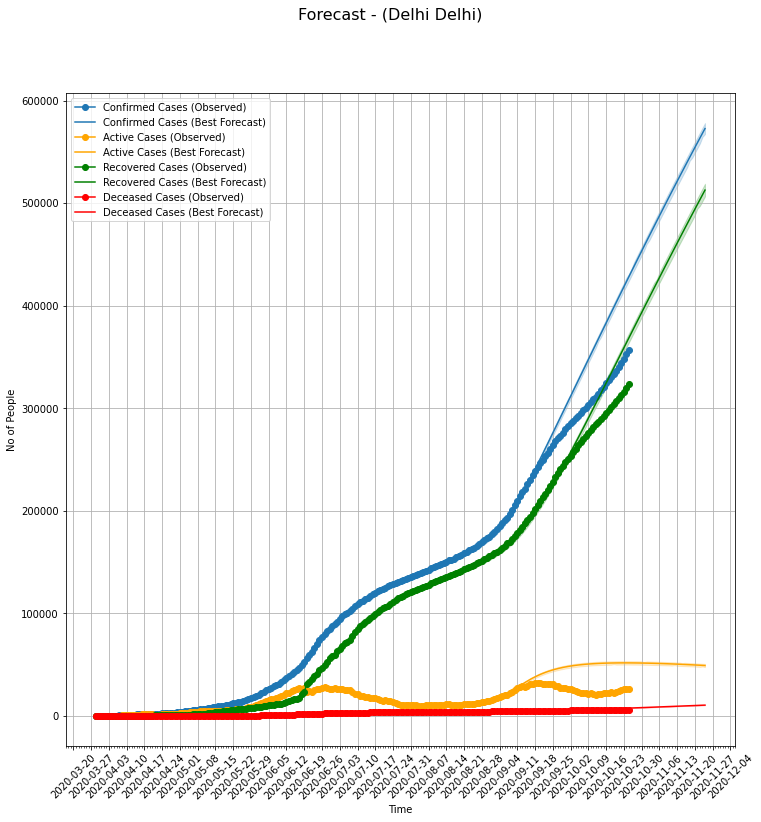

In [29]:
predictions_dict['m1']['forecasts'] = {}
predictions_dict['m1']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m1', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'], tests_done=100000)

predictions_dict['m1']['plots']['forecast_best'] = plot_forecast(predictions_dict,
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True, train_fit='m1')

# predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
#                                                                  model=config['fitting']['model'], 
#                                                                  forecast_days=config['forecast']['forecast_days'], tests_done=10000)

# kforecasts = plot_top_k_trials(predictions_dict, train_fit='m1',
#                                k=config['forecast']['num_trials_to_plot'],
#                                which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
# predictions_dict['m1']['plots']['forecasts_topk'] = {}
# for column in config['forecast']['plot_topk_trials_for_columns']:
#     predictions_dict['m1']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Create Report

In [162]:
save_dict_and_create_report_simple(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

KeyError: 'region'

## Create Output

In [163]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

KeyError: 'forecasts'

In [160]:
log_wandb(predictions_dict)

ValueError: You must call `wandb.init` in the same process before calling log

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')